In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [2]:
# Load data
df = pd.read_csv("acl_cartography.csv")
with open("acl_cartography_stats.json", "r", encoding="utf-8") as f:
    stats = json.load(f)

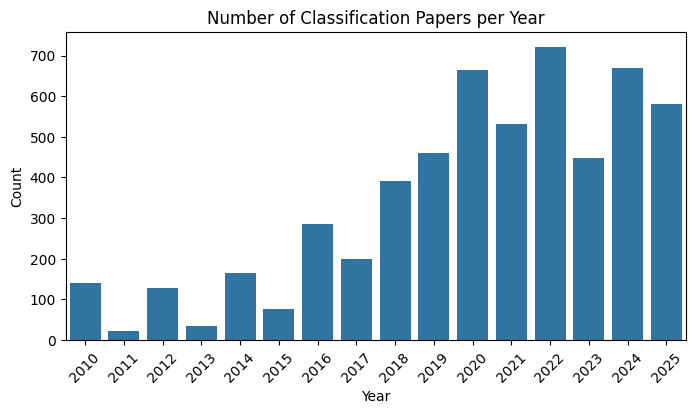

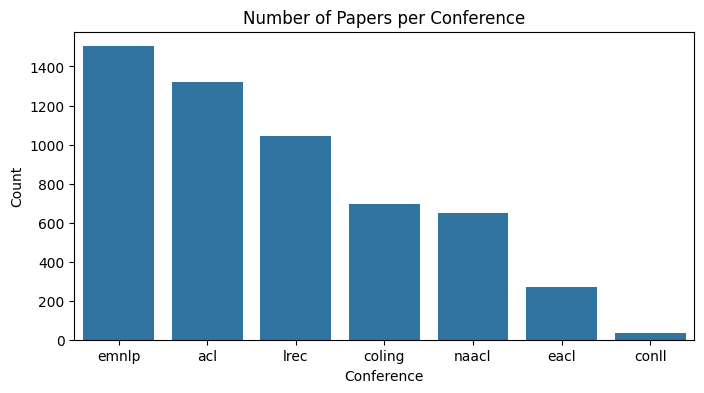

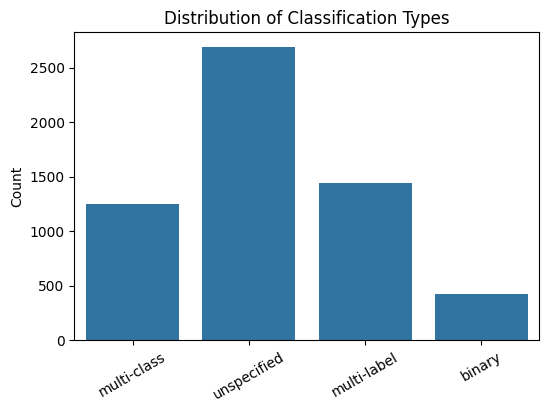

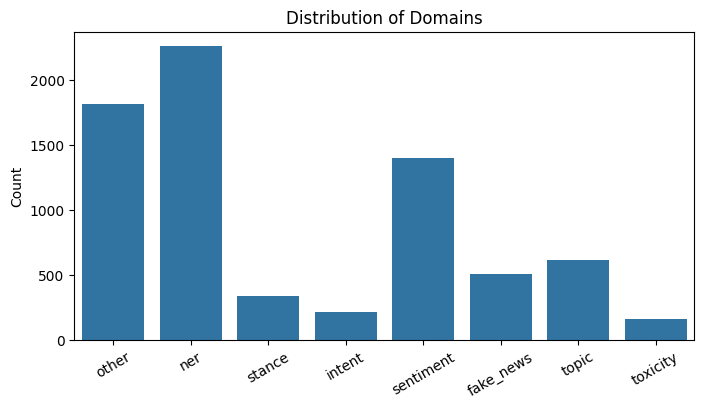

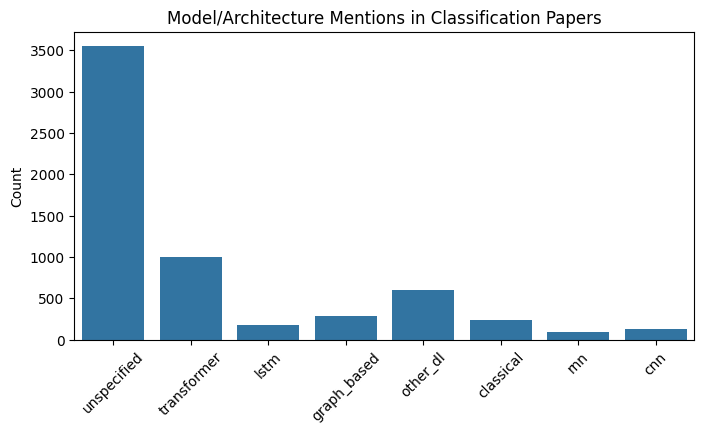

In [3]:
# --- Plot 1: Papers by Year ---
plt.figure(figsize=(8,4))
sns.barplot(x=list(stats["papers_by_year"].keys()), y=list(stats["papers_by_year"].values()))
plt.title("Number of Classification Papers per Year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

# --- Plot 2: Papers by Conference ---
plt.figure(figsize=(8,4))
sns.barplot(x=list(stats["papers_by_conference"].keys()), y=list(stats["papers_by_conference"].values()))
plt.title("Number of Papers per Conference")
plt.xlabel("Conference")
plt.ylabel("Count")
plt.show()

# --- Plot 3: Classification Type Distribution ---
plt.figure(figsize=(6,4))
sns.barplot(x=list(stats["classification_types_dist"].keys()), y=list(stats["classification_types_dist"].values()))
plt.title("Distribution of Classification Types")
plt.ylabel("Count")
plt.xticks(rotation=30)
plt.show()

# --- Plot 4: Domains Distribution ---
plt.figure(figsize=(8,4))
sns.barplot(x=list(stats["domains_dist"].keys()), y=list(stats["domains_dist"].values()))
plt.title("Distribution of Domains")
plt.ylabel("Count")
plt.xticks(rotation=30)
plt.show()

# --- Plot 5: Model Type Distribution ---
plt.figure(figsize=(8,4))
sns.barplot(x=list(stats["models_dist"].keys()), y=list(stats["models_dist"].values()))
plt.title("Model/Architecture Mentions in Classification Papers")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

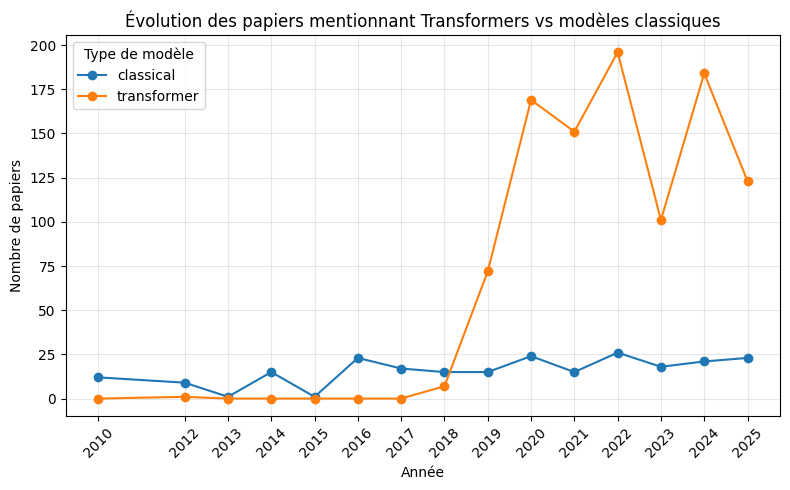

In [4]:
import ast

# --- Helper: parse the 'model_types' column (list encoded as string) ---
def parse_model_types(cell):
    if pd.isna(cell):
        return []
    if isinstance(cell, list):
        return [str(x).strip().lower() for x in cell]
    if isinstance(cell, str):
        cell = cell.strip()
        # Typical case: "['transformer', 'classical']"
        if cell.startswith("[") and cell.endswith("]"):
            try:
                parsed = ast.literal_eval(cell)
                return [str(x).strip().lower() for x in parsed]
            except Exception:
                return [cell.lower()]
        else:
            return [cell.lower()]
    return []

# Apply parsing (assumes df exists and has a 'model_types' and 'year' column)
df["model_types_parsed"] = df["model_types"].apply(parse_model_types)

# --- Build (year, category) rows for transformer vs classical ---
rows = []
for _, r in df.iterrows():
    year = r["year"]
    models = r["model_types_parsed"]
    if "transformer" in models:
        rows.append({"year": year, "model_category": "transformer"})
    if "classical" in models:
        rows.append({"year": year, "model_category": "classical"})

trend_df = pd.DataFrame(rows)

# Avoid crash if empty
if trend_df.empty:
    print("Aucun papier avec 'transformer' ou 'classical' dans model_types.")
else:
    # Group by year and category
    trend = (
        trend_df
        .groupby(["year", "model_category"])
        .size()
        .reset_index(name="count")
    )

    # Pivot to get one column per model type
    trend_pivot = (
        trend
        .pivot(index="year", columns="model_category", values="count")
        .fillna(0)
        .sort_index()
    )

    # --- Plot: Transformers vs Classical over time (pure matplotlib) ---
    plt.figure(figsize=(8, 5))
    for col in trend_pivot.columns:
        plt.plot(trend_pivot.index, trend_pivot[col], marker='o', label=col)
    plt.title("Évolution des papiers mentionnant Transformers vs modèles classiques")
    plt.xlabel("Année")
    plt.ylabel("Nombre de papiers")
    plt.legend(title="Type de modèle")
    plt.grid(alpha=0.3)
    plt.xticks(trend_pivot.index, rotation=45)
    plt.tight_layout()
    plt.show()
